In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

url = 'https://raw.githubusercontent.com/IvanJarquin/CreditRisk_Classification/main/bankloans.csv'
df = pd.read_csv(url)
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


***About Dataset***


Credit scoring is perhaps one of the most "classic" applications for predictive
modeling, to predict whether or not credit extended to an applicant will likely
result in profit or losses for the lending institution. There are many variations
and complexities regarding how exactly credit is extended to individuals,
businesses, and other organizations for various purposes (purchasing
equipment, real estate, consumer items, and so on), and using various
methods of credit (credit card, loan, delayed payment plan). But in all cases, a
the lender provides money to an individual or institution and expects to be paid
back in time with interest commensurate with the risk of default.



***Content***

-age: Age of the customers

-ed: Education level of the customers

-employ: Work Experience

-address: Address of the customer

-income: Yearly income of the customer

-debtinc: Debt to income ratio (debt divided by income)

-creddebt: Credit to debt ratio (credit used divided by the total credit available)

-othdebt: other debts

-default: Customer defaulted in the past (1= defaulted, 0=Never defaulted)



The description and the dataset was extracted from:  
https://www.kaggle.com/datasets/atulmittal199174/credit-risk-analysis-for-extending-bank-loans/data


##Exploratory data analysis


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


In [3]:
df.nunique()

age          37
ed            5
employ       33
address      32
income      129
debtinc     245
creddebt    842
othdebt     848
default       2
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,700.0,34.860000,7.997342,20.000000,29.000000,34.000000,40.000000,56.00000
ed,700.0,1.722857,0.928206,1.000000,1.000000,1.000000,2.000000,5.00000
employ,700.0,8.388571,6.658039,0.000000,3.000000,7.000000,12.000000,31.00000
address,700.0,8.278571,6.824877,0.000000,3.000000,7.000000,12.000000,34.00000
income,700.0,45.601429,36.814226,14.000000,24.000000,34.000000,55.000000,446.00000
debtinc,700.0,10.260571,6.827234,0.400000,5.000000,8.600000,14.125000,41.30000
creddebt,700.0,1.553553,2.117197,0.011696,0.369059,0.854869,1.901955,20.56131
othdebt,700.0,3.058209,3.287555,0.045584,1.044178,1.987567,3.923065,27.03360
default,700.0,0.261429,0.439727,0.000000,0.000000,0.000000,1.000000,1.00000


In [6]:
cat_feat= ['ed', 'employ', 'address', 'default']

In [7]:
def separate_categorical_feature(df: pd.DataFrame, col: str) -> [pd.Series, pd.Series]:
    df_list = []

#common_index will contain all the unique index values
    common_index = df[col].value_counts().index

#the for cycle generates a pair of lists containing the number of times default takes the value 0 or 1
    for i in range(2):
        df_list.append(df[df['default'] == i][col].value_counts().reindex(common_index, fill_value=0))

    return df_list

In [8]:
def separate_numerical_feature(df: pd.DataFrame, col: str) -> [pd.Series, pd.Series, dict]:
    df_list = []
    #here we will define the graph settings

    start, end = df[col].min(), df[col].max()

    #this if function will divide the data set by the age column in 10 groups of 5 years each group
    if col == 'age':
        size = 5  #size of the groups in years
        xbins = {'start': start, 'end': end, 'size': size}
        bins = np.arange(start, end + size, size) #array "bins" will end at the max value plus 5
    else:
        end += 1
        nbins = 10  #10 groups
        xbins = {'start': start, 'end': end, 'size': (end - start) / nbins}
        bins = np.linspace(start, end, nbins + 1) #this will generate the separation between the 10 intervals

    #this line will execute all the information stored in "bins"
    common_index = pd.cut(df[col], bins, right=False).value_counts().sort_index()

    for i in range(2):
        df_clipped = df[df['default'] == i][col]
        df_list.append(pd.Series({
            index: len(df_clipped[(df_clipped >= index.left) & (df_clipped < index.right)].index) for index in common_index.index
        }, index=common_index.index))
    #df contains 2 lists, one clasifies the information by age and the other by the default values
    return df_list + [xbins]

In [9]:
    #In this portion of code we will obtain the % of the default rates and set them as the graph's text
def set_text_args(df_not_default: pd.Series, df_default: pd.Series, args: dict) -> None:
     args['text'] = (df_default / (df_default + df_not_default)) * 100
     args['texttemplate'] = '%{text:.0f}%'
     args['textposition'] = 'outside'

In [10]:
#This portion of code relates the separate_categorical_feature values with the plotly graph
def add_bar_trace(df: pd.DataFrame, col: str, traces: list, chart_args: dict) -> None:
    # let's assing the default values
    df_not_default, df_default = separate_categorical_feature(df, col)

    for j, args in enumerate(chart_args):
        if j:
            df_agg = df_default

            set_text_args(df_not_default, df_default, args)
        else:
            df_agg = df_not_default

        # create Bar trace
        traces.append(
            go.Bar(
                x=df_agg.index,
                y=df_agg,
                **args,
            ),
        )

In [11]:
#This portion of code relates the separate_numerical_feature values with the plotly graph
def add_histogram_trace(df: pd.DataFrame, col: str, traces: list, chart_args: list) -> None:
    # separation rows on default and not default
    df_not_default, df_default, xbins = separate_numerical_feature(df, col)

    for j, args in enumerate(chart_args):
        if j:
            set_text_args(df_not_default, df_default, args)

        # create Histogram trace
        traces.append(
            go.Histogram(
                x=df[df['default'] == j][col],
                histfunc='count',
                xbins=xbins,
                **args,
            ),
        )

In [12]:
#Now it's time to create a histogram graph
def create_bar_chart(df: pd.DataFrame) -> None:
    # set up multiple traces
    traces = []
    buttons = []

    for i, col in enumerate(df.columns):
        # visible flag for first two traces
        visible = not bool(i)

        # layout attributes
        layout_attrs = {
            'title': {
                'text': f'Default rate by {col}',
                'xanchor': 'center',
                'yanchor': 'top',
                'x': 0.5,
                'y': 0.9,
            },
            'bargap': 0.2,
        }

        # chart properties
        chart_args = [
            {
                'name': 'not default',
                'visible': visible,
                'marker_color': '#228404',
            },
            {
                'name': 'default',
                'visible': visible,
                'marker_color': '#C50B0F',
            },
        ]

        # set special properties for charts and layout based upon feature
        if col in cat_feat:
            layout_attrs['xaxis'] = {'type': 'category',
                                     'categoryorder': 'array',
                                    }

            add_bar_trace(df, col, traces, chart_args)
        else:
            layout_attrs['xaxis'] = {'type': 'linear'}

            add_histogram_trace(df, col, traces, chart_args)

    #this button will help us to chose wich column it's showing in the graph
        # set visible properties for traces
        index = 2 * i
        visible_flags = 2 * [False] * len(df.columns)
        visible_flags[index] = visible_flags[index + 1] = True

        # add button
        buttons.append({'method': 'update',
                        'label': col,
                        'args': [{'visible': visible_flags}, layout_attrs],
                       })

    # add dropdown
    layout = go.Layout(
        updatemenus=[
            dict(
                buttons=buttons,
                direction='down',
                pad={'r': 10, 't': 10},
                showactive=True,
                x=0.9,
                xanchor='left',
                y=1.2,
                yanchor='top',
            ),
        ],
        barmode='stack',
        **buttons[0]['args'][-1],
    )

    fig = go.Figure(data=traces, layout=layout)

    fig.show()

In [13]:
create_bar_chart(df)

<Axes: >

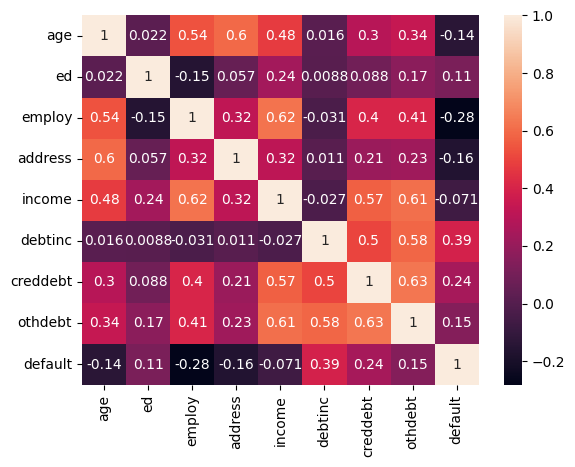

In [14]:

col_mtrx=df.corr()
sns.heatmap(data=col_mtrx, annot=True)

##Model Building

In [15]:
#Now let's split the dataset

#X contains the features and Y the target variable
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [16]:
#let's scale the predictor variables
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [17]:
#logistic regression
logreg = LogisticRegression(random_state = 0)
logreg.fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
#confusion matrix
con_ma_logreg = confusion_matrix(y_test, pred_logreg)
print(con_ma_logreg)
score_logreg = accuracy_score(y_test, pred_logreg)

[[123   8]
 [ 27  17]]


In [18]:
#decision Tree
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dtc.fit(X_train, y_train)
pred_dtc = dtc.predict(X_test)
#confusion matrix
con_ma_dtc = confusion_matrix(y_test, pred_dtc)
print(con_ma_dtc)
score_dtc = accuracy_score(y_test, pred_dtc)

[[101  30]
 [ 20  24]]


In [19]:
#random forest
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
#confusion matrix
con_ma_rfc = confusion_matrix(y_test, pred_rfc)
print(con_ma_rfc)
score_rfc = accuracy_score(y_test, pred_rfc)

[[119  12]
 [ 28  16]]


In [20]:
#support vector classifier
svc = SVC(kernel = 'linear', random_state = 0)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
#confusion matrix
con_ma_svc = confusion_matrix(y_test, pred_svc)
print(con_ma_svc)
score_svc = accuracy_score(y_test, pred_svc)

[[122   9]
 [ 26  18]]


In [21]:
mods = pd.DataFrame({
    'Model': ['logistic regression', 'Decision Tree', 'Random Forest','SVC'],
    'Score': [score_logreg, score_dtc, score_rfc,score_svc]})
mods.sort_values(by='Score', ascending=False)

,Model,Score
0,logistic regression,0.800000
3,SVC,0.800000
2,Random Forest,0.771429
1,Decision Tree,0.714286
